In [ ]:
from utilities import *

raw_data = pd.read_excel("data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data[sa.brand35]

### Firstly, we analyse the seasonality

To be able to do it, we need to filter data with a specific supermarket, variant, and pack size.

In [42]:
filter_data = data[
    (data["supermarket"] == "supermarket-A")
    & (data["variant"] == "standard")
    & (data["pack.size"] == "351 - 500 GR")
]

Check visualizations for seasonal patterns.

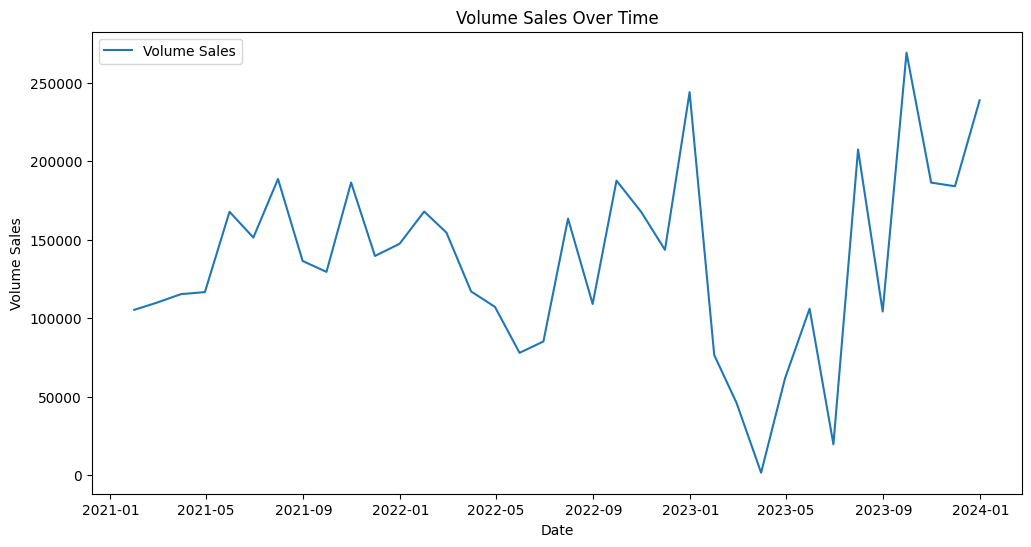

In [43]:
#plotting the time series to see if there is seasonality
plt.figure(figsize=(12, 6))
plt.plot(filter_data["date"], filter_data["volume.sales"], label="Volume Sales")
plt.xlabel("Date")
plt.ylabel("Volume Sales")
plt.title("Volume Sales Over Time")
plt.legend()
plt.show()

In theory, it seems we don't have seasonality
However, we are going to crop data in 3 parts to see if we can find any seasonal patterns

Data from 2021-01-31 to 2023-12-31
Crop 1 from 2021-01-31 to 2021-12-31
Crop 2 from 2022-01-31 to 2022-12-31
Crop 3 from 2023-01-31 to 2023-12-31


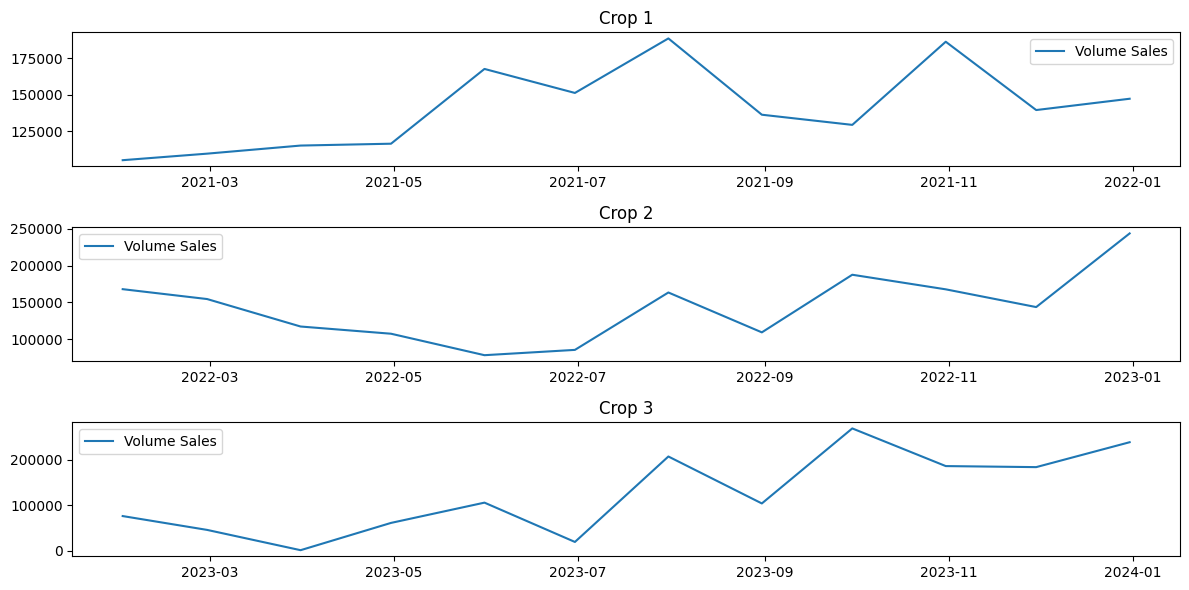

In [44]:
print("Data from {} to {}".format(filter_data["date"].min(), filter_data["date"].max()))
# print(filter_data.head())

#crop the data in 3 parts
size = int(len(filter_data) * 1/3)

crop1 = filter_data[:size]
crop2 = filter_data[size:2*size]
crop3 = filter_data[2*size:]

print("Crop 1 from {} to {}".format(crop1["date"].min(), crop1["date"].max()))
print("Crop 2 from {} to {}".format(crop2["date"].min(), crop2["date"].max()))
print("Crop 3 from {} to {}".format(crop3["date"].min(), crop3["date"].max()))

#plot the 3 crops
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(crop1["date"], crop1["volume.sales"], label="Volume Sales")
plt.title("Crop 1")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(crop2["date"], crop2["volume.sales"], label="Volume Sales")
plt.title("Crop 2")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(crop3["date"], crop3["volume.sales"], label="Volume Sales")
plt.title("Crop 3")
plt.legend()

plt.tight_layout()
plt.show()

The data seems to have an annual seasonality, which looks good. 

Later, we should use this info to select the optimum value of the parameter d.

#### We'll see seasonal decomposition, ACF, and PACF plots.

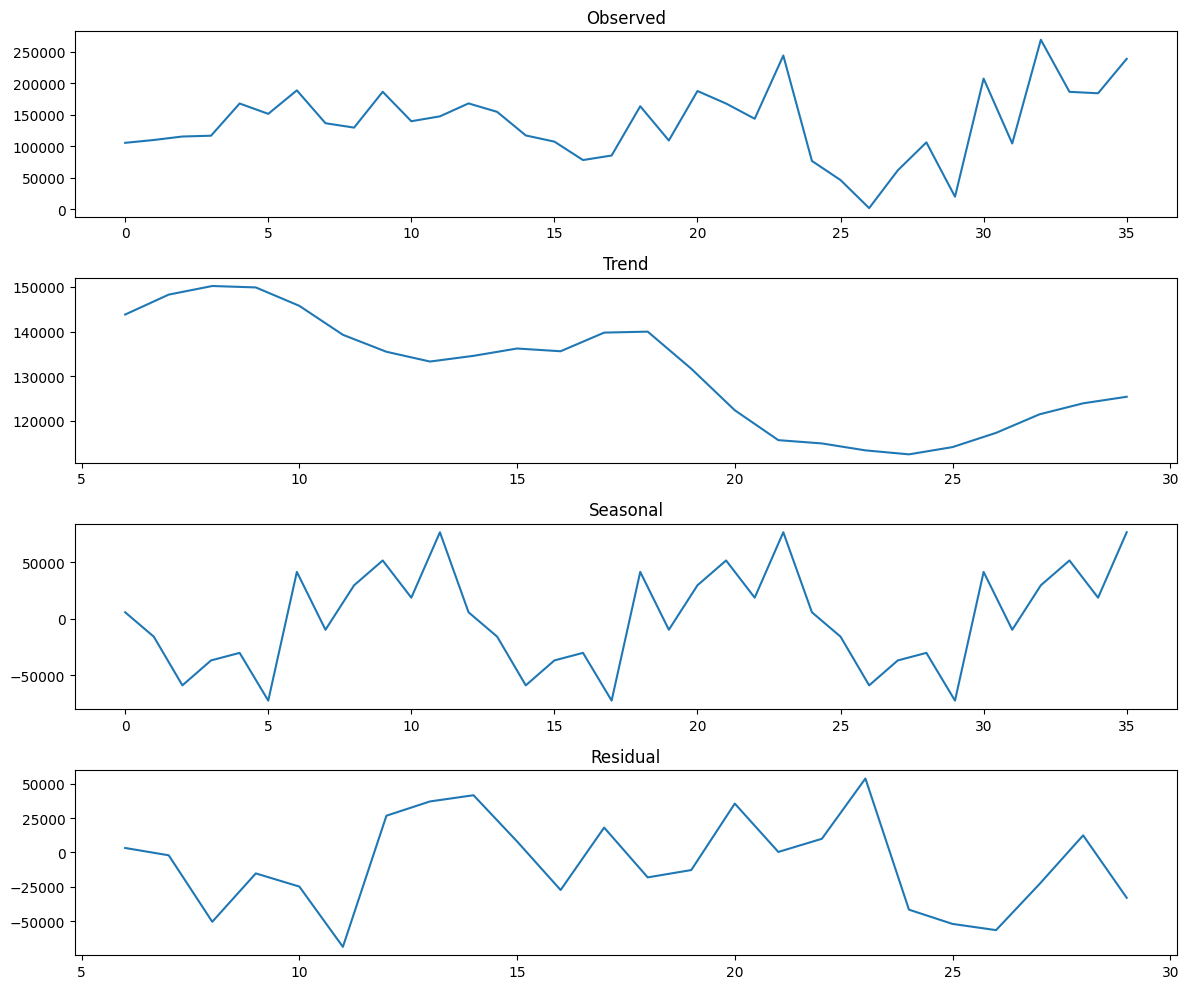

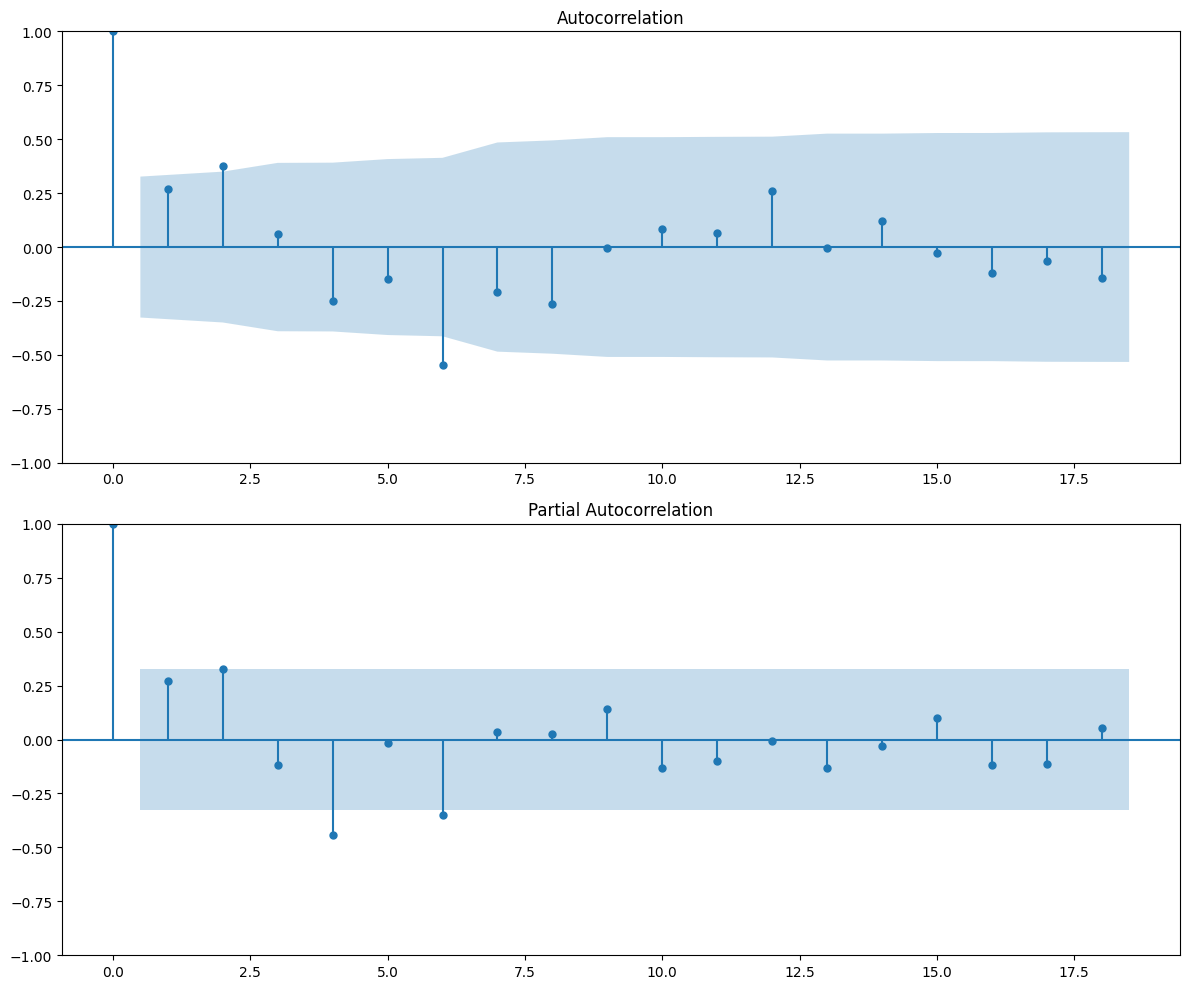

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(filter_data["volume.sales"], model='additive', period=12)

# Create a custom larger figure for the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
axes[0].plot(result.observed)
axes[0].set_title('Observed')
axes[1].plot(result.trend)
axes[1].set_title('Trend')
axes[2].plot(result.seasonal)
axes[2].set_title('Seasonal')
axes[3].plot(result.resid)
axes[3].set_title('Residual')
plt.tight_layout()
plt.show()

#ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF in the same figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(filter_data["volume.sales"], lags=18, ax=axes[0])
plot_pacf(filter_data["volume.sales"], lags=18, ax=axes[1])
plt.tight_layout()
plt.show()

##### Now, we're gonna check it with ADF test and KPSS test

In [46]:
# Set date as index
filter_data.set_index("date", inplace=True) 

Test stationarity series original
-------------------------------------
ADF Statistic: -4.065039528699303, p-value: 0.0011057352983620142
KPSS Statistic: 0.07964268328146942, p-value: 0.1

Test stationarity series differenced
-------------------------------------
ADF Statistic: -3.218568123224036, p-value: 0.01893472930292822
KPSS Statistic: 0.08510787636980381, p-value: 0.1

Test stationarity series second differenced
-------------------------------------
ADF Statistic: -2.2842944883516565, p-value: 0.17708335274861436
KPSS Statistic: 0.091038414738134, p-value: 0.1
----------------------------------------------------------------------------------------------------


<Axes: title={'center': 'Diferenciación orden 2'}, xlabel='date'>

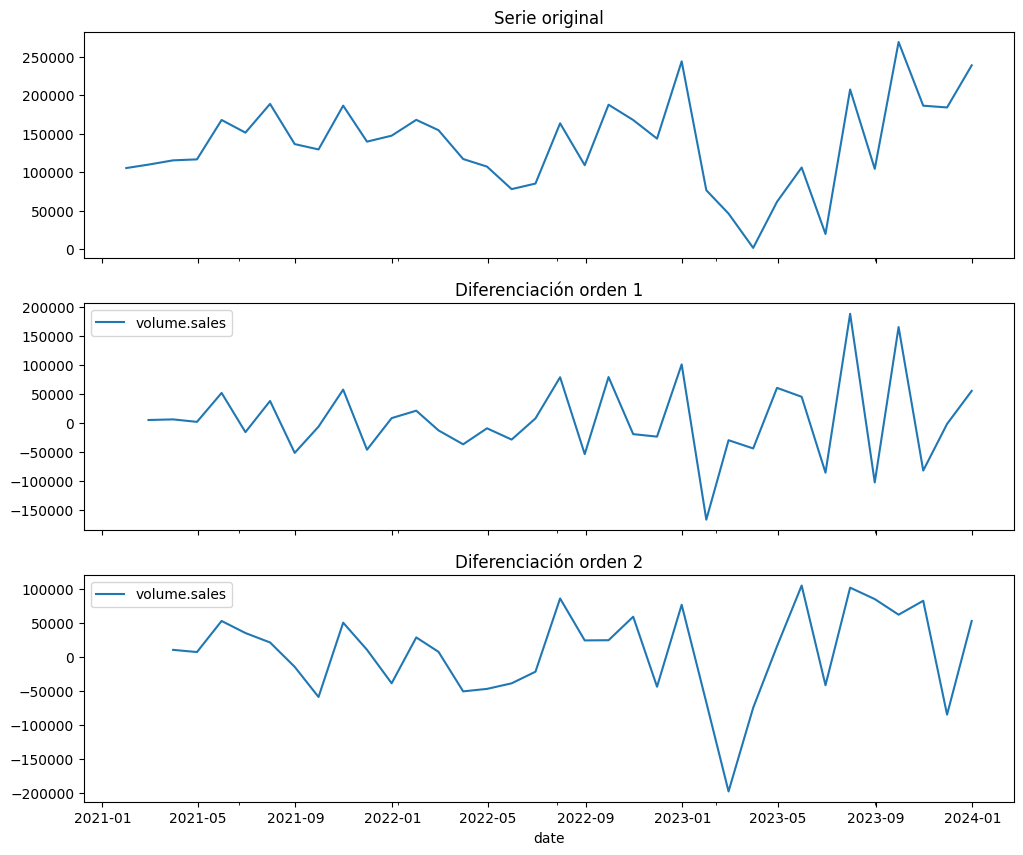

In [47]:
from statsmodels.tsa.stattools import kpss

print("=" * 100)

# Only apply diff() to numeric columns
filter_data_diff = filter_data[['volume.sales']].diff().dropna()
filter_data_diff2 = filter_data[['volume.sales']].diff(periods=2).dropna()

print('Test stationarity series original')
print('-------------------------------------')

adfuller_result = adfuller(filter_data['volume.sales'])
kpss_result = kpss(filter_data['volume.sales'])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity series differenced')
print('-------------------------------------')

adfuller_result_diff = adfuller(filter_data_diff['volume.sales'])
kpss_result_diff = kpss(filter_data_diff['volume.sales'])
print(f'ADF Statistic: {adfuller_result_diff[0]}, p-value: {adfuller_result_diff[1]}')
print(f'KPSS Statistic: {kpss_result_diff[0]}, p-value: {kpss_result_diff[1]}')

print('\nTest stationarity series second differenced')
print('-------------------------------------')

adfuller_result_diff2 = adfuller(filter_data_diff2['volume.sales'])
kpss_result_diff2 = kpss(filter_data_diff2['volume.sales'])
print(f'ADF Statistic: {adfuller_result_diff2[0]}, p-value: {adfuller_result_diff2[1]}')
print(f'KPSS Statistic: {kpss_result_diff2[0]}, p-value: {kpss_result_diff2[1]}')

print("-" * 100)
# Gráfico series
# ==============================================================================
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)
filter_data['volume.sales'].plot(ax=axs[0], title='Serie original')
filter_data_diff.plot(ax=axs[1], title='Diferenciación orden 1')
filter_data_diff2.plot(ax=axs[2], title='Diferenciación orden 2')


We see how the ADF test shows a p-value of 0.01, indicating that we can reject the null hypothesis of non-stationarity. So, we can conclude that the time series is stationary.

ADF test: 
- Null hypothesis (H0): it is not stationary.
- Alternative scenario (H1): the series is stationary.
  
The KPSS test shows a statistic of 0.07, which is below the critical value of 0.739 at the 5% significance level. This indicates that we fail to reject the null hypothesis of stationarity. Therefore, we can conclude that the time series is stationary according to the KPSS test as well.

In original data, the p-value of KPSS is 0.1 above the 5% significance level, indicating that we accept the null hypothesis and *is not necessary to difference the series*. Ans it's stationary.

KPSS test: 
- Null hypothesis (H0): the series is stationary
- Alternative scenario (H1): the series is not stationary

Conclusion: we'll use the parameter d=0 in ARIMA and ARIMAX models.